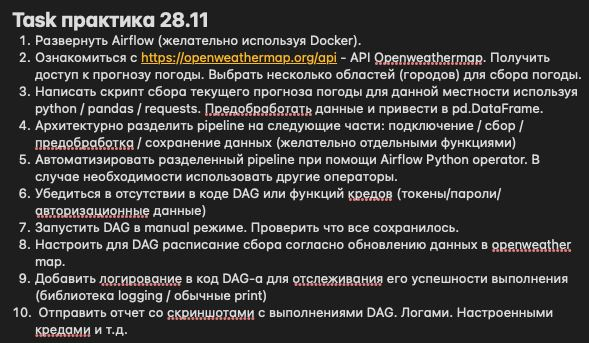


In [75]:
from dotenv import load_dotenv
import requests
import os
import pandas as pd
from datetime import datetime

In [76]:
load_dotenv()

api_key = os.getenv("OPENWEATHER_API_KEY")

In [77]:
cities = {
    "vdk": (43.1332, 131.9),
    "khv": (48.4814, 135.0721),
}

In [ ]:
def get_data(
    lat: float,
    lon: float,
) -> None:
    req = requests.get(
        url=f"https://api.openweathermap.org/data/2.5/weather",
        params={
            "lat": lat,
            "lon": lon,
            "appid": api_key,
        },
    )

    try:
        data = req.json()
    except Exception as e:
        print(req.status_code, req.content, str(e))
        return

    return data

In [79]:
def parse_data(data: dict) -> dict:
    return {
        "temp": data["main"].get("temp"),
        "temp_min": data["main"].get("temp_min"),
        "temp_max": data["main"].get("temp_max"),
        "feels_like": data["main"].get("feels_like"),
        "pressure": data["main"].get("pressure"),
        "humidity": data["main"].get("humidity"),
        "wind_speed": data["wind"].get("speed"),
        "dt": data.get("dt"),
        "weather": data["weather"][0].get("main"),
    }

In [85]:
from datetime import UTC


def prep_data(data: dict) -> dict:
    def work_temp(key: str):
        data[key] = data[key] - 273.15

    [
        work_temp(key)
        for key in [
            "temp",
            "temp_min",
            "temp_max",
            "feels_like",
        ]
    ]

    dt = datetime.fromtimestamp(data["dt"], tz=UTC)

    data["year"] = dt.year
    data["month"] = dt.month
    data["day"] = dt.day
    data["hour"] = dt.hour
    data["minute"] = dt.minute

    data.pop("dt")

    return data

In [81]:
def write_data(
    df: pd.DataFrame,
    data: dict,
) -> pd.DataFrame:
    return pd.concat(
        [df, pd.DataFrame([data])],
        ignore_index=True,
    )

In [82]:
data = get_data(lat=cities["vdk"][0], lon=cities["vdk"][1])

In [86]:
df = pd.DataFrame()
parsed = parse_data(data)
print(parsed)
prepped = prep_data(parsed)
print(parsed)
df = write_data(df=df, data=prepped)

{'temp': 271.61, 'temp_min': 271.61, 'temp_max': 271.61, 'feels_like': 264.78, 'pressure': 1016, 'humidity': 38, 'wind_speed': 8.1, 'dt': 1764306117, 'weather': 'Clear'}
{'temp': -1.5399999999999636, 'temp_min': -1.5399999999999636, 'temp_max': -1.5399999999999636, 'feels_like': -8.370000000000005, 'pressure': 1016, 'humidity': 38, 'wind_speed': 8.1, 'weather': 'Clear', 'year': 2025, 'month': 11, 'day': 28, 'hour': 5, 'minute': 1}


In [87]:
df.head(5)

,temp,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,weather,year,month,day,hour,minute
0,-1.54,-1.54,-1.54,-8.37,1016,38,8.1,Clear,2025,11,28,5,1


In [3]:
from airflow.models import Variable
from airflow.sdk import dag, task
from datetime import datetime, timedelta
import requests
import pandas as pd
import os

DATA_PATH = "/Users/poslam/Downloads/projects/fefu/7/ds/ia/prac/28_11_25/data/weather.csv"
CITIES = {
    "vdk": (43.1332, 131.9),
    "khv": (48.4814, 135.0721),
}

default_args = {
    "owner": "airflow",
    "depends_on_past": False,
    "retries": 1,
    "retry_delay": timedelta(minutes=5),
}


@dag(
    default_args=default_args,
    schedule="0 * * * *",
    start_date=datetime(2025, 11, 28),
    catchup=False,
    tags=["weather"],
)
def weather_pipeline():
    @task()
    def fetch_weather(lat: float, lon: float) -> dict:
        api_key = Variable.get("OPENWEATHER_API_KEY")
        resp = requests.get(
            "https://api.openweathermap.org/data/2.5/weather",
            params={
                "lat": lat,
                "lon": lon,
                "appid": api_key,
            },
            timeout=15,
        )
        resp.raise_for_status()
        return resp.json()

    @task()
    def parse_data(raw: dict) -> dict:
        return {
            "temp": raw["main"].get("temp"),
            "temp_min": raw["main"].get("temp_min"),
            "temp_max": raw["main"].get("temp_max"),
            "feels_like": raw["main"].get("feels_like"),
            "pressure": raw["main"].get("pressure"),
            "humidity": raw["main"].get("humidity"),
            "wind_speed": raw.get("wind", {}).get("speed"),
            "dt": raw.get("dt"),
            "weather": raw.get("weather", [{}])[0].get("main"),
        }

    @task()
    def prep_data(parsed: dict) -> dict:
        for key in ("temp", "temp_min", "temp_max", "feels_like"):
            if parsed.get(key) is not None:
                parsed[key] = parsed[key] - 273.15

        dt = datetime.fromtimestamp(parsed.pop("dt"))
        parsed.update(
            {
                "year": dt.year,
                "month": dt.month,
                "day": dt.day,
                "hour": dt.hour,
            }
        )
        return parsed

    @task()
    def write_data(row: dict) -> str:
        os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)
        df = pd.DataFrame([row])
        if os.path.exists(DATA_PATH):
            df.to_csv(DATA_PATH, mode="a", header=False, index=False)
        else:
            df.to_csv(DATA_PATH, index=False)
        return DATA_PATH

    for name, (lat, lon) in CITIES.items():
        raw = fetch_weather(lat, lon)
        parsed = parse_data(raw)
        prepped = prep_data(parsed)
        write_data(prepped)


dag_w = weather_pipeline()

In [7]:
from airflow.api.client.local_client import Client

c = Client(None, None)
c.trigger_dag(dag_id="weather_pipeline")

OperationalError: (sqlite3.OperationalError) no such table: dag
[SQL: SELECT dag.dag_id, dag.is_paused, dag.is_stale, dag.last_parsed_time, dag.last_parse_duration, dag.last_expired, dag.fileloc, dag.relative_fileloc, dag.bundle_name, dag.bundle_version, dag.owners, dag.dag_display_name, dag.description, dag.timetable_summary, dag.timetable_description, dag.asset_expression, dag.deadline, dag.max_active_tasks, dag.max_active_runs, dag.max_consecutive_failed_dag_runs, dag.has_task_concurrency_limits, dag.has_import_errors, dag.next_dagrun, dag.next_dagrun_data_interval_start, dag.next_dagrun_data_interval_end, dag.next_dagrun_create_after 
FROM dag 
WHERE dag.dag_id = ?]
[parameters: ('weather_pipeline',)]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [5]:
from airflow import settings
from airflow.models import DagBag
from airflow.utils import timezone
from airflow.utils.state import State

dagbag = DagBag()
dag = dagbag.get_dag("weather_pipeline")

execution_date = timezone.utcnow()
session = settings.Session()

dag.create_dagrun(
    run_id=f"manual__{execution_date.isoformat()}",
    execution_date=execution_date,
    start_date=execution_date,
    state=State.RUNNING,
    external_trigger=True,
    conf=None,
    session=session,
)

2025-11-28T05:24:31.844837Z [info     ] Filling up the DagBag from /Users/poslam/airflow/dags [airflow.models.dagbag.DagBag] loc=dagbag.py:593


2025-11-28T05:24:31.873553Z [warning  ] Could not import DAGs in example_local_kubernetes_executor.py [unusual_prefix_0251d03cfc63ab1682bf6c11f544c7866653b45e_example_local_kubernetes_executor] loc=example_local_kubernetes_executor.py:39
Traceback (most recent call last):
  File "/Users/poslam/Downloads/projects/fefu/7/ds/.venv/lib/python3.13/site-packages/airflow/example_dags/example_local_kubernetes_executor.py", line 37, in <module>
    from kubernetes.client import models as k8s
ModuleNotFoundError: No module named 'kubernetes'
2025-11-28T05:24:31.876566Z [warning  ] Install Kubernetes dependencies with: pip install apache-airflow[cncf.kubernetes] [unusual_prefix_0251d03cfc63ab1682bf6c11f544c7866653b45e_example_local_kubernetes_executor] loc=example_local_kubernetes_executor.py:40
2025-11-28T05:24:33.101848Z [warning  ] The example_kubernetes_executor example DAG requires the kubernetes provider. Please install it with: pip install apache-airflow[cncf.kubernetes] [unusual_prefix_15

OperationalError: (sqlite3.OperationalError) no such table: dag
[SQL: SELECT dag.dag_id, dag.is_paused, dag.is_stale, dag.last_parsed_time, dag.last_parse_duration, dag.last_expired, dag.fileloc, dag.relative_fileloc, dag.bundle_name, dag.bundle_version, dag.owners, dag.dag_display_name, dag.description, dag.timetable_summary, dag.timetable_description, dag.asset_expression, dag.deadline, dag.max_active_tasks, dag.max_active_runs, dag.max_consecutive_failed_dag_runs, dag.has_task_concurrency_limits, dag.has_import_errors, dag.next_dagrun, dag.next_dagrun_data_interval_start, dag.next_dagrun_data_interval_end, dag.next_dagrun_create_after 
FROM dag 
WHERE dag.dag_id = ?]
[parameters: ('weather_pipeline',)]
(Background on this error at: https://sqlalche.me/e/20/e3q8)